# Visualize data

In order to start making interpretations we will generate two visualizations of our data

1. We will verify that the simulated dataset is a good representation of our original input dataset by visually comparing the structures in the two datasets projected onto UMAP space.

2. We will plot the PCA projected data after adding experiments to examine how the technical variation shifted the data.

3. We plot the PCA projected data after correcting for the technical variation introduced by the experiments and examine the effectiveness of the correction method by comparing the data before and after the correction.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import random
import glob
from plotnine import (ggplot, 
                      geom_point, 
                      aes, 
                      labs,
                      facet_wrap, 
                      scale_colour_manual,
                      guides, 
                      guide_legend, 
                      theme_bw, 
                      theme,  
                      element_text,
                      element_rect,
                      ggsave)

from sklearn.decomposition import PCA
from keras.models import load_model
import umap

import warnings
warnings.filterwarnings(action='ignore')

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# User parameters
NN_architecture = 'NN_2500_30'
analysis_name = 'analysis_1'
lst_num_partitions = [1,2,3,5,10,20,30,50,70,100]

In [3]:
# Load data
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))    # base dir on repo
local_dir = "/home/alexandra/Documents"                          # base dir on local machine for data storage

NN_dir = base_dir + "/models/" + NN_architecture
latent_dim = NN_architecture.split('_')[-1]

normalized_data_file = os.path.join(
    base_dir,
    "data",
    "input",
    "train_set_normalized.pcl")

model_encoder_file = glob.glob(os.path.join( ## Make more explicit name here
    NN_dir,
    "tybalt_2layer_{}latent_encoder_model.h5".format(latent_dim)))[0]

weights_encoder_file = glob.glob(os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_encoder_weights.h5".format(latent_dim)))[0]

model_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_decoder_model.h5".format(latent_dim)))[0]

weights_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_decoder_weights.h5".format(latent_dim)))[0]

partition_dir = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "partition_simulated",
    analysis_name)

simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")

permuted_simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "permuted_simulated_data.txt.xz")

In [4]:
# Output files
umap_overlay_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "analysis_1_umap_overlay.png")

pca_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "analysis_1_pca_variation.png")

pca_correct_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "analysis_1_pca_correction.png")

## 1. Visualize simulated data in UMAP space

In [5]:
# Load saved models
loaded_model = load_model(model_encoder_file)
loaded_decode_model = load_model(model_decoder_file)

loaded_model.load_weights(weights_encoder_file)
loaded_decode_model.load_weights(weights_decoder_file)

In [6]:
# Read data
normalized_data = pd.read_table(
    normalized_data_file,
    header=0,
    sep='\t',
    index_col=0).T

simulated_data = pd.read_table(
    simulated_data_file,
    header=0,
    sep='\t',
    index_col=0)

simulated_data.drop(columns="experiment_id", inplace=True)

print(normalized_data.shape)
print(simulated_data.shape)

(950, 5549)
(765, 5549)


In [7]:
normalized_data.head(10)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.466871,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.352020,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.392405,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.398308,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.407801,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814
control1aerobic_Pae_G1a.CEL,0.365512,0.572967,0.417762,0.663096,0.424846,0.606590,0.378900,0.224257,0.161582,0.074461,...,0.491161,0.565151,0.595824,0.382989,0.352268,0.250905,0.362161,0.487777,0.729434,0.483384
control1_anaerobic_Pae_G1a.CEL,0.689254,0.723461,0.510094,0.801569,0.619374,0.937262,0.138600,0.298615,0.306533,0.032482,...,0.754845,0.711126,0.589279,0.542699,0.591066,0.421389,0.392671,0.686055,0.911163,0.585208
control2aerobic_Pae_G1a.CEL,0.353000,0.580626,0.302544,0.639624,0.281793,0.687343,0.462645,0.000000,0.107961,0.093163,...,0.466139,0.545104,0.487957,0.330583,0.419139,0.328478,0.298493,0.254059,0.588305,0.406311
control2_anaerobic_Pae_G1a.CEL,0.674305,0.680740,0.515478,0.747121,0.656701,0.910654,0.149744,0.262492,0.263528,0.019910,...,0.775338,0.653142,0.642205,0.550935,0.565532,0.458622,0.426767,0.701314,0.886074,0.556363
control3aerobic_Pae_G1a.CEL,0.399186,0.653977,0.328755,0.692895,0.482482,0.618446,0.308135,0.191401,0.201170,0.020375,...,0.560889,0.654797,0.493961,0.454766,0.464733,0.456465,0.348577,0.503229,0.718768,0.474649


In [8]:
simulated_data.head(10)

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM199982.CEL,0.646,0.706,0.399,0.642,0.419,0.292,0.424,0.468,0.454,0.496,...,0.317,0.535,0.604,0.489,0.526,0.263,0.378,0.444,0.572,0.655
GSM199983.CEL,0.648,0.706,0.402,0.644,0.424,0.294,0.417,0.469,0.451,0.495,...,0.319,0.540,0.611,0.494,0.529,0.266,0.382,0.448,0.577,0.657
GSM199984.CEL,0.598,0.670,0.433,0.638,0.443,0.364,0.367,0.447,0.433,0.506,...,0.373,0.529,0.601,0.487,0.499,0.330,0.392,0.494,0.587,0.636
GSM199985.CEL,0.614,0.695,0.455,0.667,0.445,0.357,0.364,0.465,0.458,0.481,...,0.345,0.542,0.606,0.498,0.509,0.304,0.400,0.500,0.595,0.645
GSM199986.CEL,0.606,0.680,0.444,0.652,0.446,0.362,0.364,0.456,0.444,0.494,...,0.359,0.536,0.605,0.494,0.504,0.318,0.398,0.498,0.593,0.642
GSM234928.CEL,0.748,0.660,0.375,0.705,0.471,0.316,0.608,0.555,0.534,0.044,...,0.060,0.346,0.523,0.460,0.647,0.062,0.410,0.416,0.673,0.778
GSM234929.CEL,0.327,0.334,0.183,0.379,0.359,0.478,0.363,0.432,0.389,0.320,...,0.147,0.294,0.294,0.387,0.402,0.664,0.782,0.452,0.366,0.345
GSM242671.CEL,0.466,0.678,0.469,0.777,0.279,0.207,0.606,0.378,0.340,0.523,...,0.175,0.317,0.320,0.210,0.096,0.169,0.076,0.224,0.471,0.577
GSM242676.CEL,0.668,0.842,0.603,0.846,0.558,0.403,0.228,0.518,0.570,0.393,...,0.275,0.448,0.433,0.425,0.346,0.098,0.090,0.434,0.693,0.711
GSM242677.CEL,0.460,0.704,0.475,0.786,0.249,0.194,0.609,0.330,0.302,0.559,...,0.213,0.296,0.329,0.182,0.075,0.163,0.091,0.166,0.436,0.561


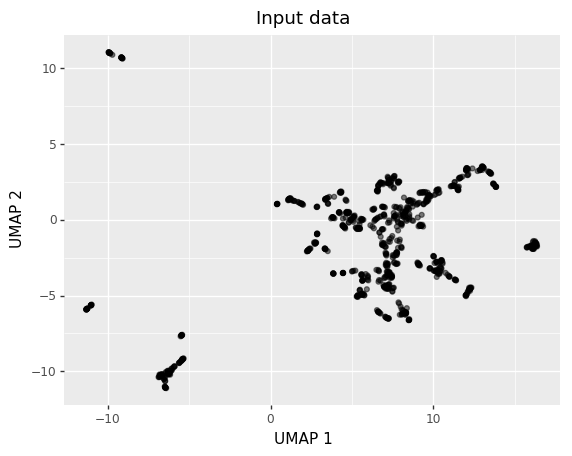

<ggplot: (-9223363258331495378)>


In [9]:
# UMAP embedding of original input data

# Get and save model
model = umap.UMAP(random_state=randomState).fit(normalized_data)

input_data_UMAPencoded = model.transform(normalized_data)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=normalized_data.index,
                                         columns=['1','2'])


g_input = ggplot(input_data_UMAPencoded_df, aes(x='1',y='2')) \
    + geom_point(alpha=0.5) \
    + labs(x = "UMAP 1", y = "UMAP 2", title = "Input data") \

print(g_input)

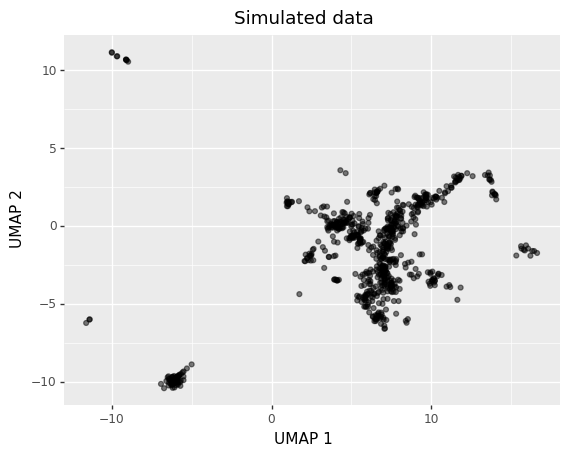

<ggplot: (8778531608822)>


In [10]:
# UMAP embedding of simulated data
simulated_data_UMAPencoded = model.transform(simulated_data)
simulated_data_UMAPencoded_df = pd.DataFrame(data=simulated_data_UMAPencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])


g_sim = ggplot(simulated_data_UMAPencoded_df, aes(x='1',y='2')) \
    + geom_point(alpha=0.5) \
    + labs(x = "UMAP 1", y = "UMAP 2", title = "Simulated data") \

print(g_sim)

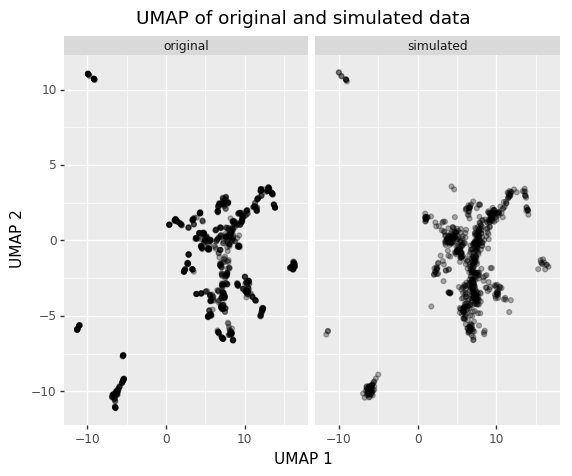

<ggplot: (8778593969903)>

In [11]:
# Side by side original input vs simulated data

# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot
ggplot(combined_data_df, aes(x='1', y='2')) \
+ geom_point(alpha=0.3) \
+ facet_wrap('~dataset') \
+ labs(x = "UMAP 1", y = "UMAP 2", title = "UMAP of original and simulated data") \

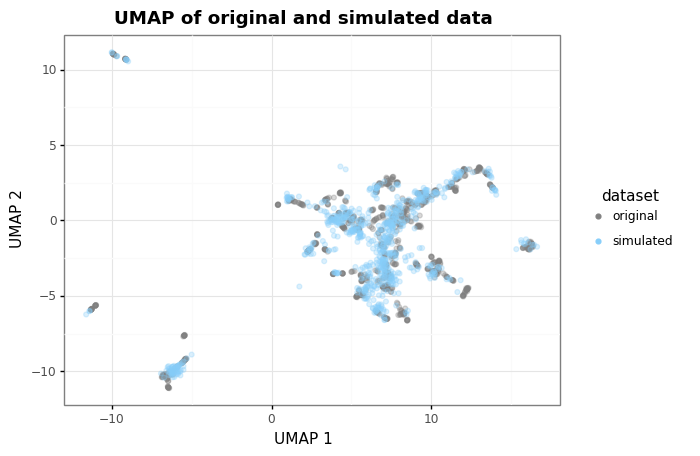

<ggplot: (8778594125425)>


In [12]:
# Overlay original input vs simulated data

# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot
g_input_sim = ggplot(combined_data_df, aes(x='1', y='2')) \
+ geom_point(aes(color='dataset'), alpha=0.3) \
+ labs(x = "UMAP 1", y = "UMAP 2", title = "UMAP of original and simulated data") \
+ theme_bw() \
+ theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    plot_title=element_text(weight='bold')
) \
+ guides(colour=guide_legend(override_aes={'alpha': 1})) \
+ scale_colour_manual(["grey", '#87CEFA']) 

print(g_input_sim)
ggsave(plot = g_input_sim, filename = umap_overlay_file, dpi=300)

## 2. Visualize effects of multiple experiments in PCA space

Plotting PCA of 1 partition vs 1 partition...
[0.23113275 0.19210764]


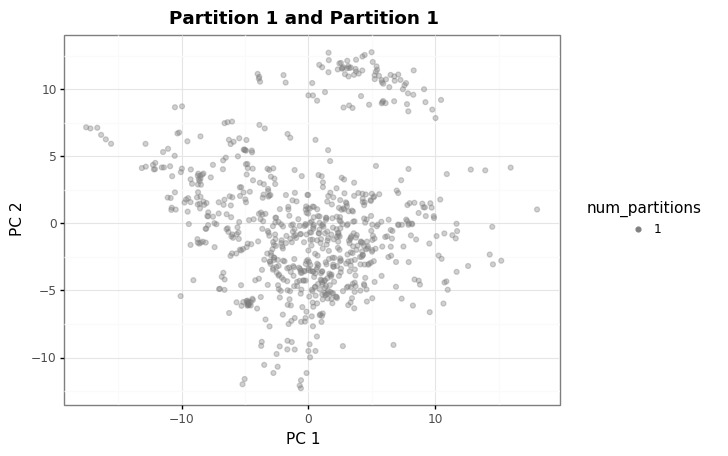

<ggplot: (-9223363258260558213)>
Plotting PCA of 1 partition vs 2 partition...
[0.27641982 0.13411552]


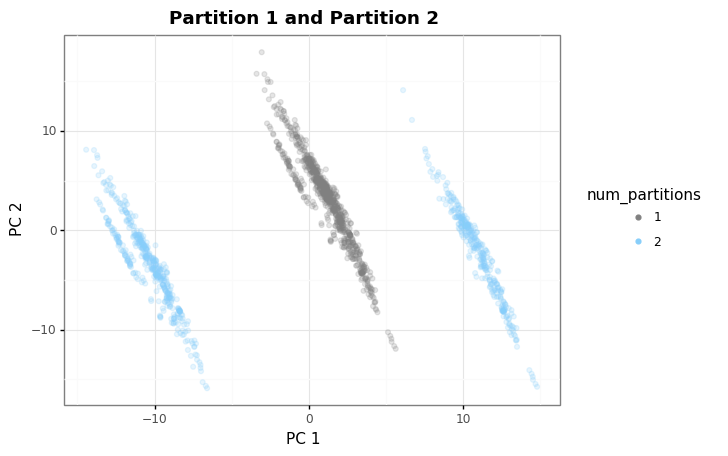

<ggplot: (-9223363258323257319)>
Plotting PCA of 1 partition vs 3 partition...
[0.18736395 0.16111258]


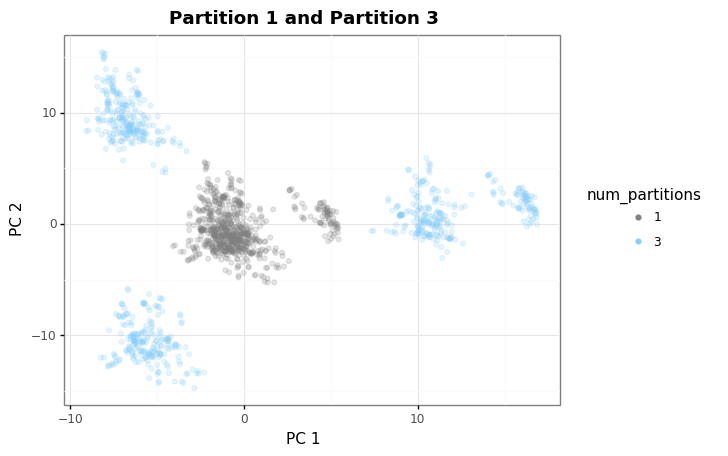

<ggplot: (-9223363258260814802)>
Plotting PCA of 1 partition vs 5 partition...
[0.15817611 0.1335174 ]


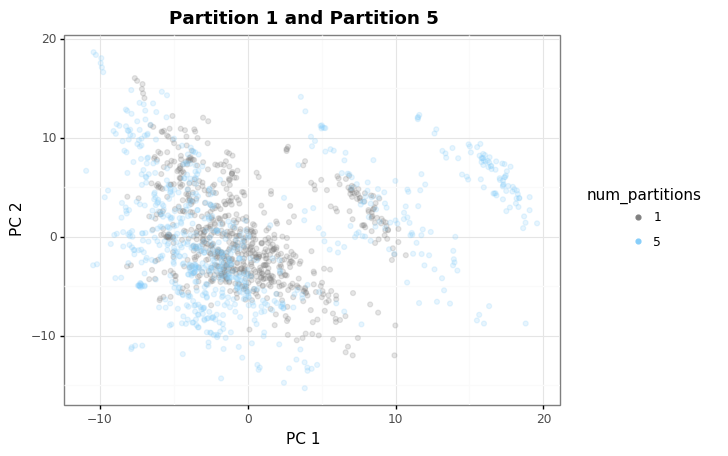

<ggplot: (8778594129202)>
Plotting PCA of 1 partition vs 10 partition...
[0.13994386 0.12420446]


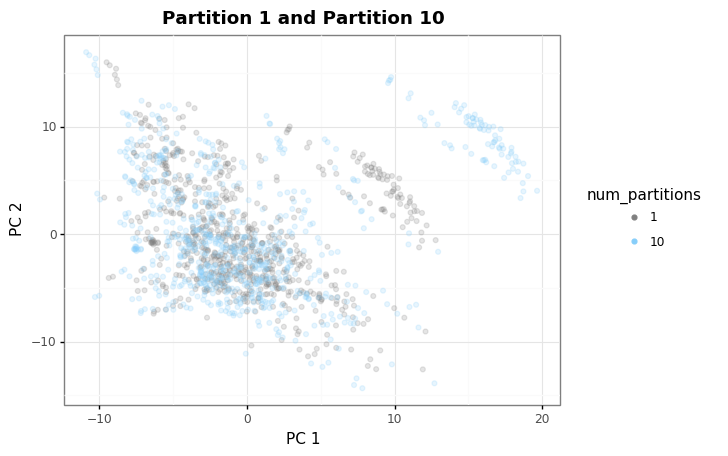

<ggplot: (8778594040363)>
Plotting PCA of 1 partition vs 20 partition...
[0.1368464  0.12397532]


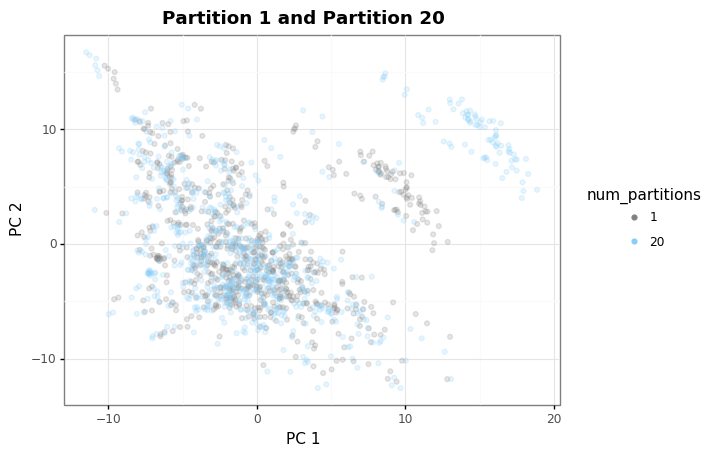

<ggplot: (-9223363258330877531)>
Plotting PCA of 1 partition vs 30 partition...
[0.13333495 0.12011458]


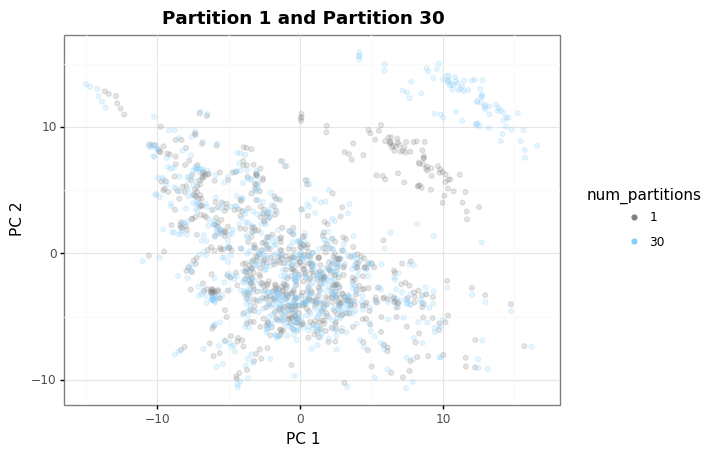

<ggplot: (-9223363258260653631)>
Plotting PCA of 1 partition vs 50 partition...
[0.13360576 0.12037754]


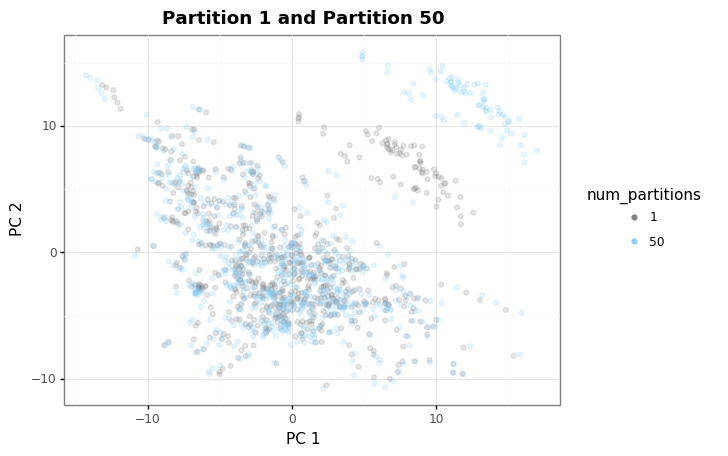

<ggplot: (-9223363258260709709)>
Plotting PCA of 1 partition vs 70 partition...
[0.13262076 0.11982931]


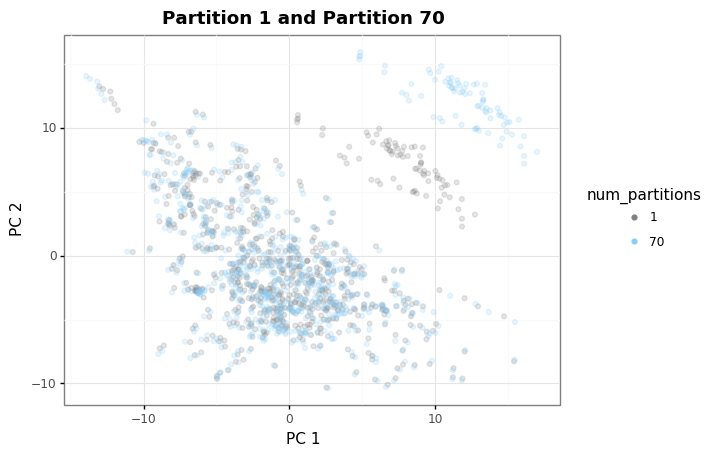

<ggplot: (8778594170551)>
Plotting PCA of 1 partition vs 100 partition...
[0.13097167 0.1189747 ]


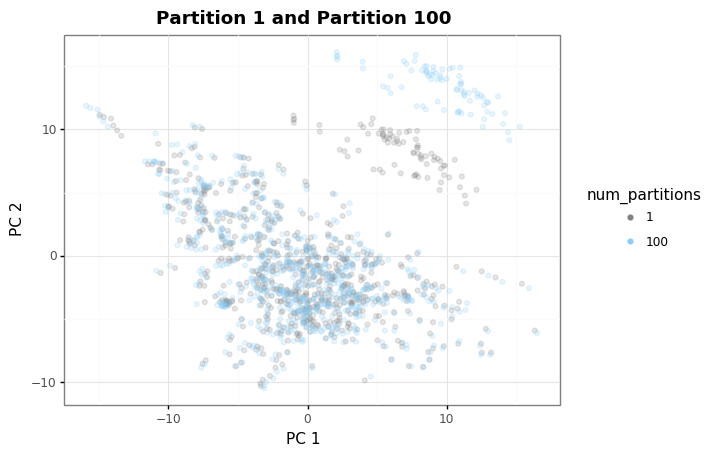

<ggplot: (-9223363258260595470)>
CPU times: user 29.2 s, sys: 10.2 s, total: 39.4 s
Wall time: 21 s


In [13]:
%%time

all_data_df = pd.DataFrame()

# Get batch 1 data
partition_1_file = os.path.join(
    partition_dir,
    "Partition_1.txt.xz")

partition_1 = pd.read_table(
    partition_1_file,
    header=0,
    index_col=0,
    sep='\t')


for i in lst_num_partitions:
    print('Plotting PCA of 1 partition vs {} partition...'.format(i))
    
    # Simulated data with all samples in a single partition
    original_data_df =  partition_1.copy()
    
    # Add grouping column for plotting
    original_data_df['num_partitions'] = '1'
    
    # Get data with additional partitions added
    partition_other_file = os.path.join(
        partition_dir,
        "Partition_"+str(i)+".txt.xz")

    partition_other = pd.read_table(
        partition_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Simulated data with i partitions
    partition_data_df =  partition_other
    
    # Add grouping column for plotting
    partition_data_df['num_partitions'] = str(i)
    
    # Concatenate datasets together
    combined_data_df = pd.concat([original_data_df, partition_data_df])

    # PCA projection
    pca = PCA(n_components=2)

    # Encode expression data into 2D PCA space
    combined_data_numeric_df = combined_data_df.drop(['num_partitions'], axis=1)
    combined_data_PCAencoded = pca.fit_transform(combined_data_numeric_df)


    combined_data_PCAencoded_df = pd.DataFrame(combined_data_PCAencoded,
                                               index=combined_data_df.index,
                                               columns=['PC1', 'PC2']
                                              )
                                              
    # Variance explained
    print(pca.explained_variance_ratio_)  
    
    # Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
    combined_data_PCAencoded_df['num_partitions'] = combined_data_df['num_partitions']
    
    # Add column that designates which batch effect comparision (i.e. comparison of 1 batch vs 5 batches
    # is represented by label = 5)
    combined_data_PCAencoded_df['comparison'] = str(i)
    
    # Concatenate ALL comparisons
    all_data_df = pd.concat([all_data_df, combined_data_PCAencoded_df])
    
    # Plot individual comparisons
    print(ggplot(combined_data_PCAencoded_df, aes(x='PC1', y='PC2')) \
          + geom_point(aes(color='num_partitions'), alpha=0.2) \
          + labs(x = "PC 1", y = "PC 2", title = "Partition 1 and Partition {}".format(i))\
          + theme_bw() \
          + theme(
                legend_title_align = "center",
                plot_background=element_rect(fill='white'),
                legend_key=element_rect(fill='white', colour='white'), 
                plot_title=element_text(weight='bold')
            ) \
          + guides(colour=guide_legend(override_aes={'alpha': 1})) \
          + scale_colour_manual(["grey", '#87CEFA'])
         )             

In [14]:
# Convert 'num_experiments' into categories to preserve the ordering
lst_num_partitions_str = [str(i) for i in lst_num_partitions]
num_partitions_cat = pd.Categorical(all_data_df['num_partitions'], categories=lst_num_partitions_str)

# Convert 'comparison' into categories to preserve the ordering
comparison_cat = pd.Categorical(all_data_df['comparison'], categories=lst_num_partitions_str)

# Assign to a new column in the df
all_data_df = all_data_df.assign(num_partitions_cat = num_partitions_cat)
all_data_df = all_data_df.assign(comparison_cat = comparison_cat)

# Rename header
all_data_df.columns = ['PC1', 'PC2', 'num_partitions', 'comparison', 'No. of partitions', 'Comparison']

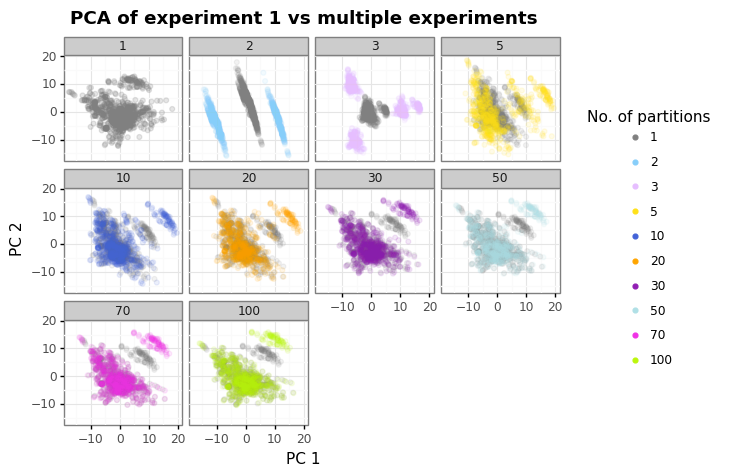

<ggplot: (8778594170632)>


In [15]:
# Plot all comparisons in one figure
g_pca = ggplot(all_data_df, aes(x='PC1', y='PC2')) \
+ geom_point(aes(color='No. of partitions'), alpha=0.1) \
+ facet_wrap('~Comparison') \
+ labs(x = "PC 1", y = "PC 2", title = "PCA of experiment 1 vs multiple experiments") \
+ theme_bw() \
+ theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    plot_title=element_text(weight='bold')
) \
+ guides(colour=guide_legend(override_aes={'alpha': 1})) \
+ scale_colour_manual(["grey", '#87CEFA', '#e6beff', '#ffe119', '#4363d8', '#FFA500', 
                      '#911eb4', '#B0E0E6', '#f032e6', '#bcf60c', '#fabebe', '#008080'])

print(g_pca)
ggsave(plot = g_pca, filename = pca_file, dpi=300)

## Visualize multiple experiments in UMAP space

Plotting UMAP of 10-PCA of 1 partition vs 1 partitions...
[0.23113275 0.19210764 0.0874545  0.04730975 0.03429918 0.03223475
 0.02935939 0.02564367 0.02283604 0.02122408]


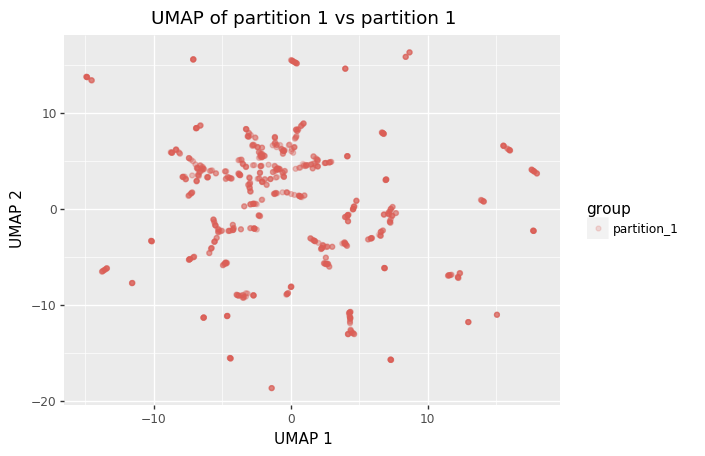

<ggplot: (8778594180104)>
Plotting UMAP of 10-PCA of 1 partition vs 2 partitions...
[0.27641982 0.13411552 0.12373644 0.11350787 0.05324108 0.0290244
 0.02103873 0.01955629 0.01799545 0.01572442]


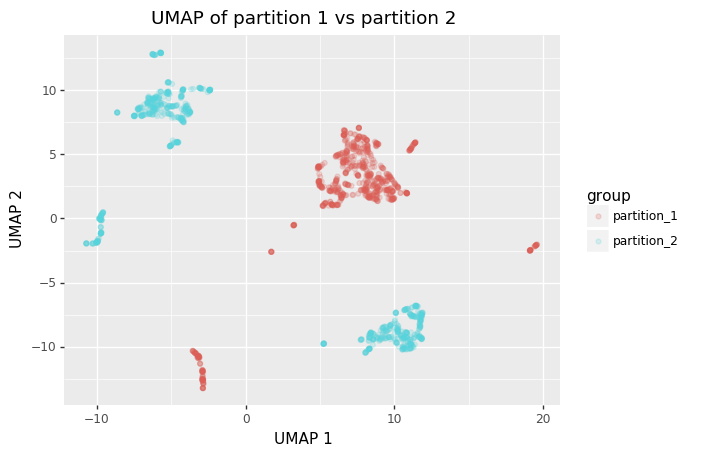

<ggplot: (-9223363258260595694)>
Plotting UMAP of 10-PCA of 1 partition vs 3 partitions...
[0.18736395 0.16111258 0.13276105 0.10348635 0.08169077 0.0481646
 0.02752233 0.01943336 0.01866343 0.0169146 ]


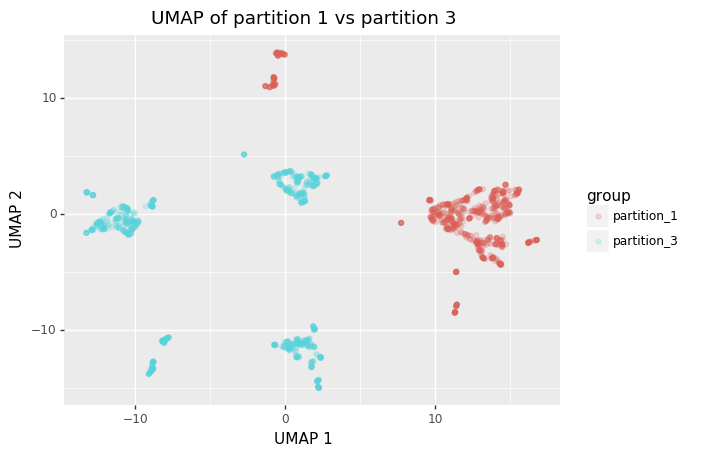

<ggplot: (-9223363258339652506)>
Plotting UMAP of 10-PCA of 1 partition vs 5 partitions...
[0.15817611 0.1335174  0.10232797 0.08785556 0.07884415 0.07178969
 0.04737442 0.04556133 0.02570777 0.01923821]


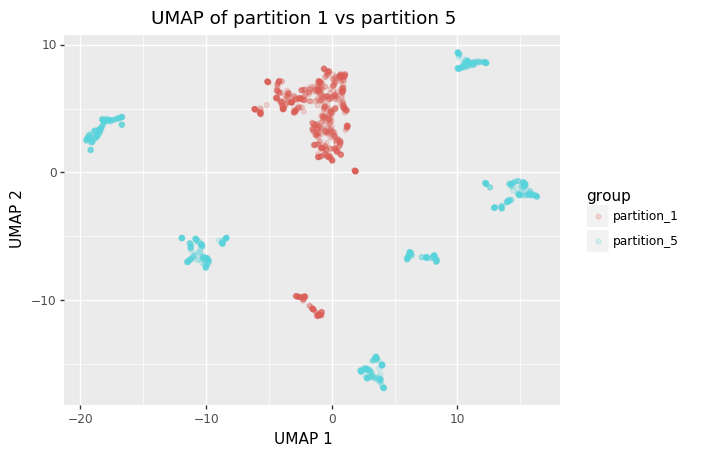

<ggplot: (-9223363258260688503)>
Plotting UMAP of 10-PCA of 1 partition vs 10 partitions...
[0.13994386 0.12420446 0.06895689 0.05853333 0.05637397 0.05397178
 0.04758708 0.04186697 0.03610386 0.03477028]


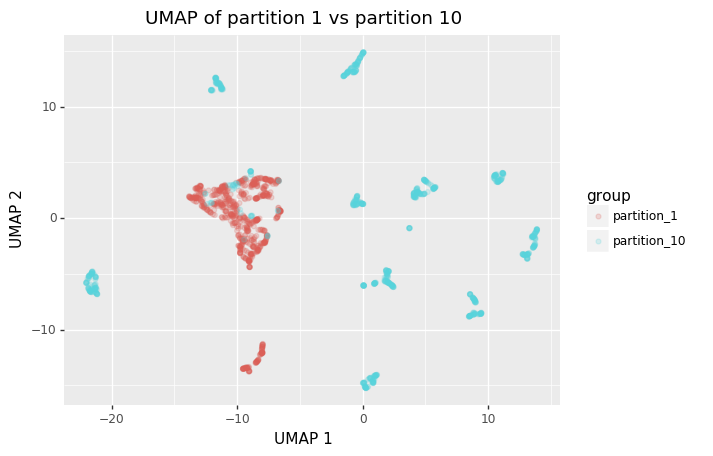

<ggplot: (8778593918668)>
Plotting UMAP of 10-PCA of 1 partition vs 20 partitions...
[0.1368464  0.12397532 0.06032208 0.03866948 0.0380198  0.035516
 0.03415431 0.0313751  0.02900814 0.02752724]


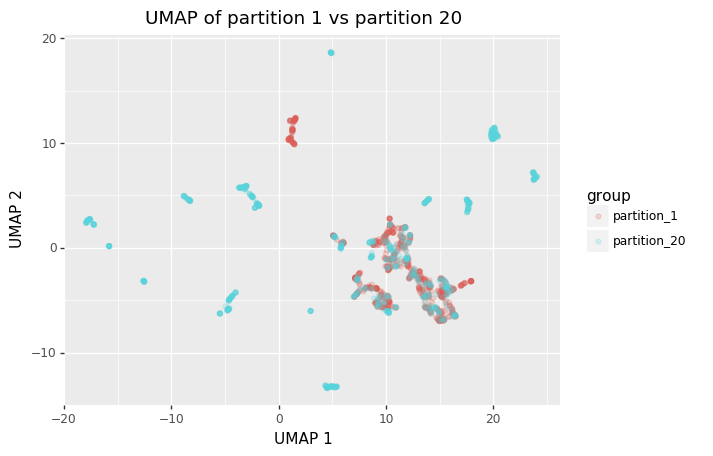

<ggplot: (8778489890652)>
Plotting UMAP of 10-PCA of 1 partition vs 30 partitions...
[0.13333495 0.12011458 0.05805212 0.03676061 0.03072695 0.03044621
 0.02798076 0.02544363 0.02345024 0.02315784]


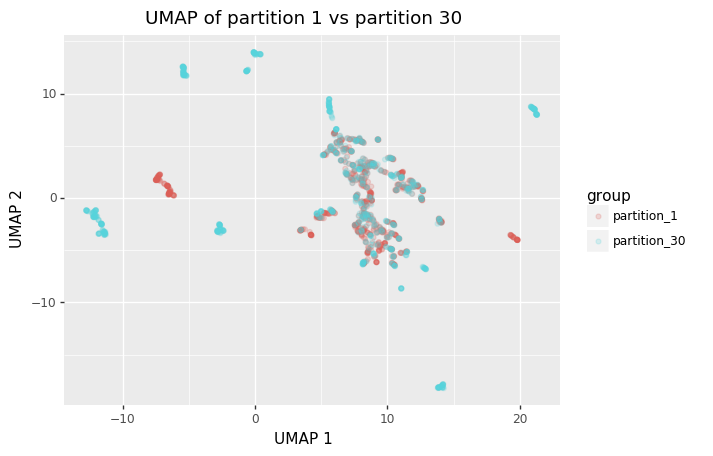

<ggplot: (-9223363258364975328)>
Plotting UMAP of 10-PCA of 1 partition vs 50 partitions...
[0.13360576 0.12037754 0.05660114 0.03293712 0.02693535 0.02502617
 0.02452159 0.02257585 0.02016953 0.01974491]


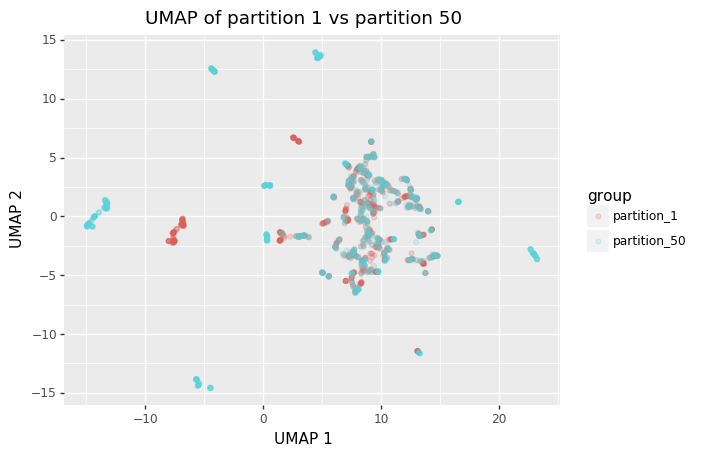

<ggplot: (8778489799926)>
Plotting UMAP of 10-PCA of 1 partition vs 70 partitions...
[0.13262076 0.11982931 0.05754531 0.03271484 0.031945   0.02645283
 0.02235816 0.02158762 0.02042059 0.01938078]


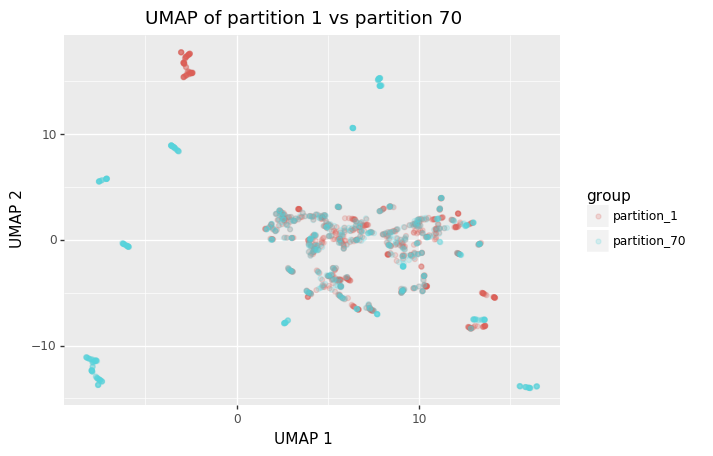

<ggplot: (-9223363258365139305)>
Plotting UMAP of 10-PCA of 1 partition vs 100 partitions...
[0.13097167 0.1189747  0.05758168 0.03246735 0.02581548 0.02395006
 0.02179126 0.01955837 0.01913017 0.01818465]


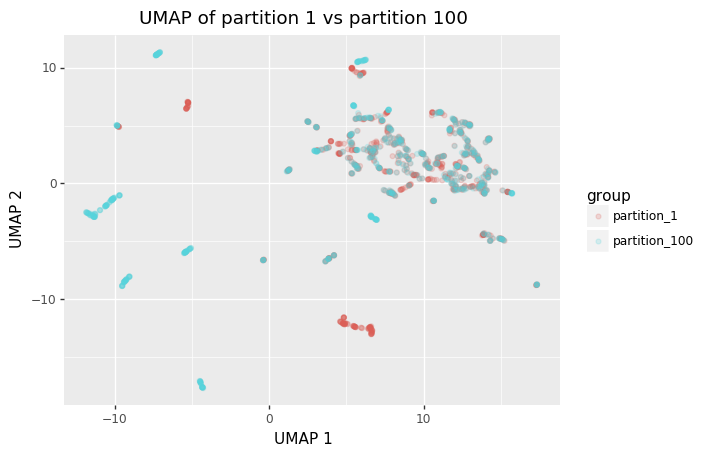

<ggplot: (8778489856348)>
CPU times: user 1min 4s, sys: 16.1 s, total: 1min 20s
Wall time: 51.4 s


In [16]:
%%time

all_data_df = pd.DataFrame()

# Get batch 1 data
partition_1_file = os.path.join(
    partition_dir,
    "Partition_1.txt.xz")

partition_1 = pd.read_table(
    partition_1_file,
    header=0,
    index_col=0,
    sep='\t')


for i in lst_num_partitions:
    print('Plotting UMAP of 10-PCA of 1 partition vs {} partitions...'.format(i))
    
    # Simulated data with all samples in a single batch
    original_data_df =  partition_1.copy()
    
    # Add grouping column for plotting
    original_data_df['group'] = 'partition_1'
    
    # Get data with additional partitions added
    partition_other_file = os.path.join(
        partition_dir,
        "Partition_"+str(i)+".txt.xz")

    partition_other = pd.read_table(
        partition_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Simulated data with i partitions
    partition_data_df =  partition_other
    
    # Add grouping column for plotting
    partition_data_df['group'] = "partition_{}".format(i)
    
    # Concatenate datasets together
    combined_data_df = pd.concat([original_data_df, partition_data_df])
    
    # PCA projection
    pca = PCA(n_components=10)

    # Encode expression data into 2D PCA space
    combined_data_numeric_df = combined_data_df.drop(['group'], axis=1)
    combined_data_PCAencoded = pca.fit_transform(combined_data_numeric_df)


    combined_data_PCAencoded_df = pd.DataFrame(combined_data_PCAencoded,
                                               index=combined_data_df.index,
                                              )
    
    # Variance explained
    print(pca.explained_variance_ratio_)  
                                              
   
    # Encode 10-dim PCA compressed expression data into UMAP space
    combined_data_UMAPencoded = umap.UMAP(random_state=randomState).fit_transform(combined_data_PCAencoded_df)
    combined_data_UMAPencoded_df = pd.DataFrame(data=combined_data_UMAPencoded,
                                             index=combined_data_PCAencoded_df.index,
                                             columns=['UMAP1','UMAP2'])
    
    
    # Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
    combined_data_UMAPencoded_df['group'] = combined_data_df['group']
    
    # Add column that designates which batch effect comparision (i.e. comparison of 1 batch vs 5 batches
    # is represented by label = 5)
    combined_data_UMAPencoded_df['num_partitions'] = str(i)
    
    # Concatenate ALL comparisons
    all_data_df = pd.concat([all_data_df, combined_data_UMAPencoded_df])
    
    # Plot individual comparisons
    print(ggplot(combined_data_UMAPencoded_df, aes(x='UMAP1', y='UMAP2')) \
          + geom_point(aes(color='group'), alpha=0.2) \
          + labs(x = "UMAP 1", y = "UMAP 2", title = "UMAP of partition 1 vs partition {}".format(i)) \
         )

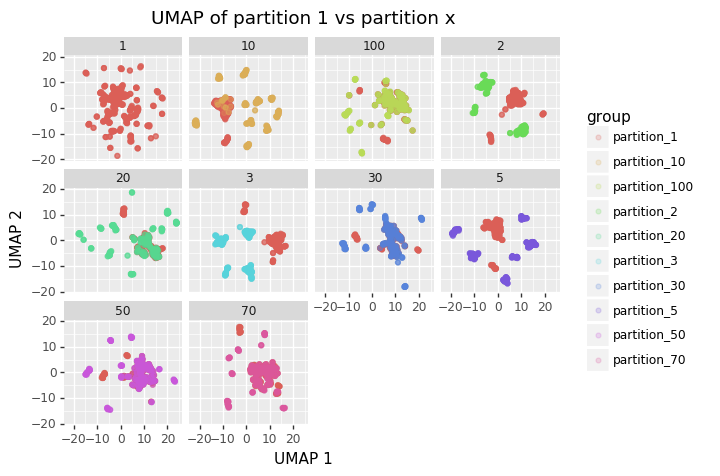

<ggplot: (-9223363258323087160)>

In [17]:
# Plot all comparisons in one figure
ggplot(all_data_df, aes(x='UMAP1', y='UMAP2')) \
+ geom_point(aes(color='group'), alpha=0.2) \
+ facet_wrap('~num_partitions') \
+ labs(x = "UMAP 1", y = "UMAP 2", title = "UMAP of partition 1 vs partition x") \

**Note:** 

1. We are using PCA space to visualize the simulated data with different numbers of experiments added in order to detect the effect of the variance added by the different experiments.  UMAP is focused on trying to find the optimal low dimensional representation of the data that preserves the topological structures in the data in high dimensional space.  

2. In order to examine the structure that is captured in using 10 PCs (set by the user), we plotted the UMAP projection of the gene expression data compressed into the top 10 PCs.  We can see that there is some structure in the 10-PCA data.

## 3. Visualize variance corrected experiment data

Plotting PCA of 1 partition vs 1 partitions...


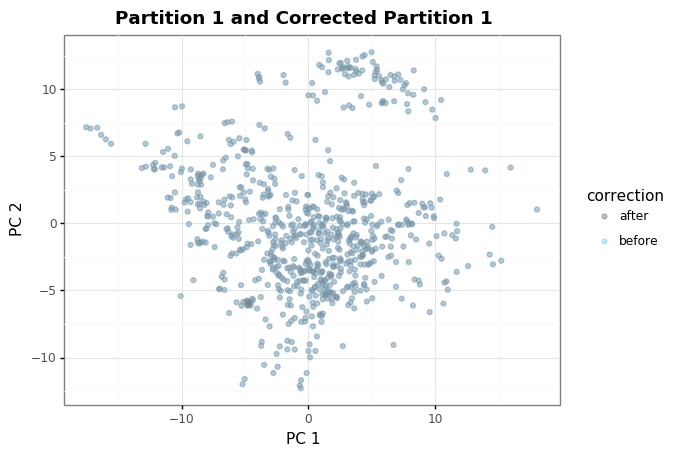

<ggplot: (-9223363258382000405)>
Plotting PCA of 1 partition vs 2 partitions...


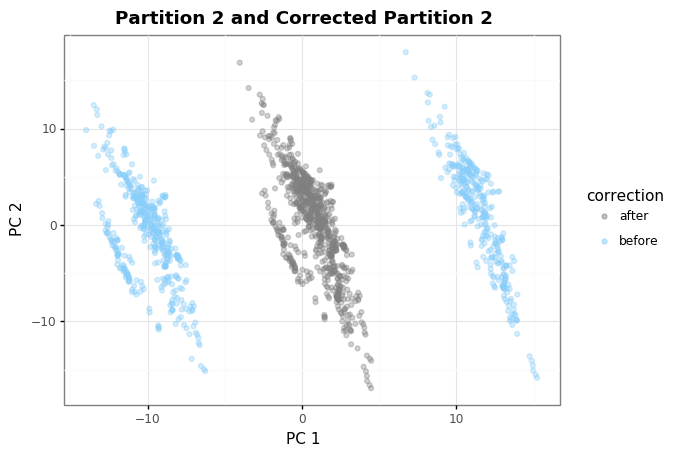

<ggplot: (8778472951686)>
Plotting PCA of 1 partition vs 3 partitions...


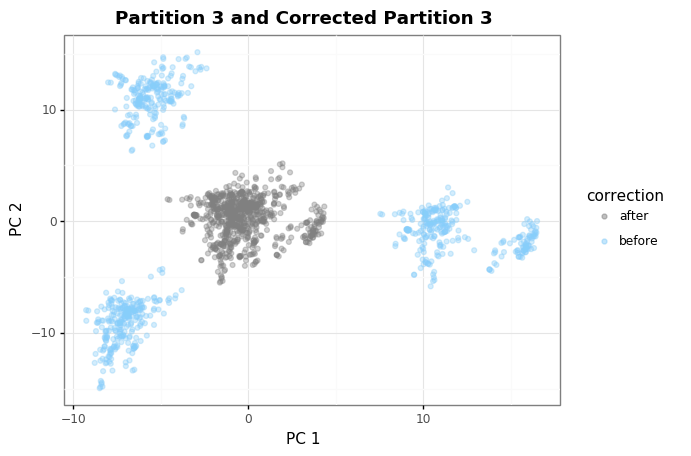

<ggplot: (8778594118292)>
Plotting PCA of 1 partition vs 5 partitions...


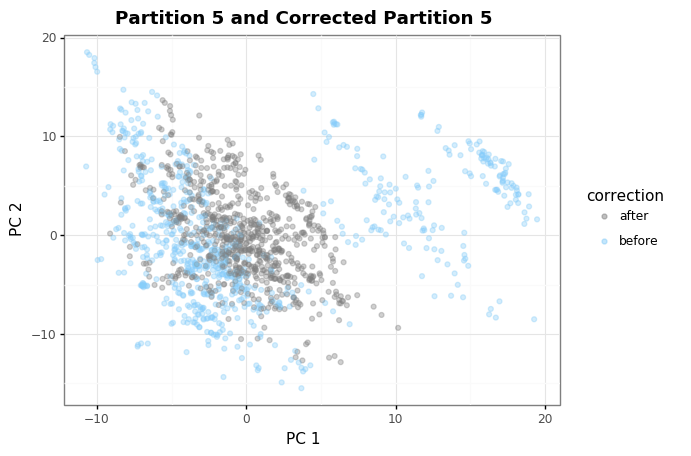

<ggplot: (-9223363258260650685)>
Plotting PCA of 1 partition vs 10 partitions...


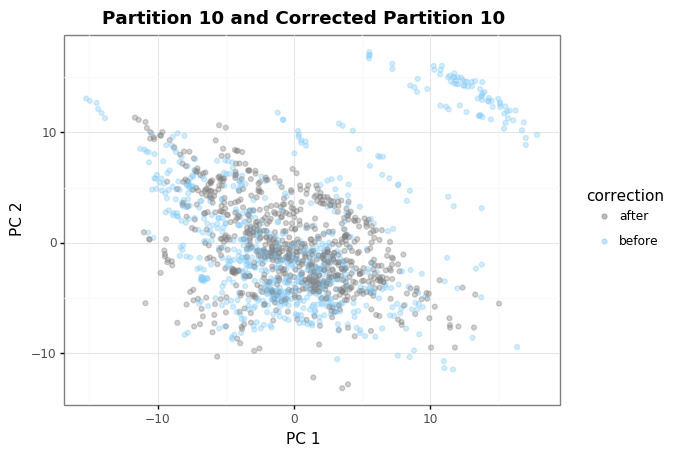

<ggplot: (8778514729136)>
Plotting PCA of 1 partition vs 20 partitions...


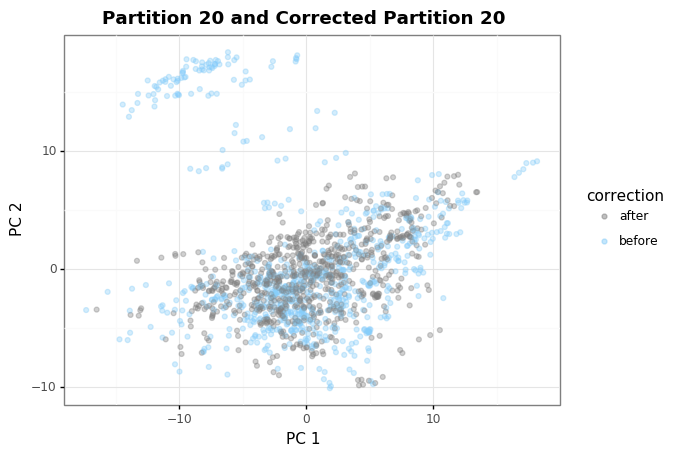

<ggplot: (-9223363258381841646)>
Plotting PCA of 1 partition vs 30 partitions...


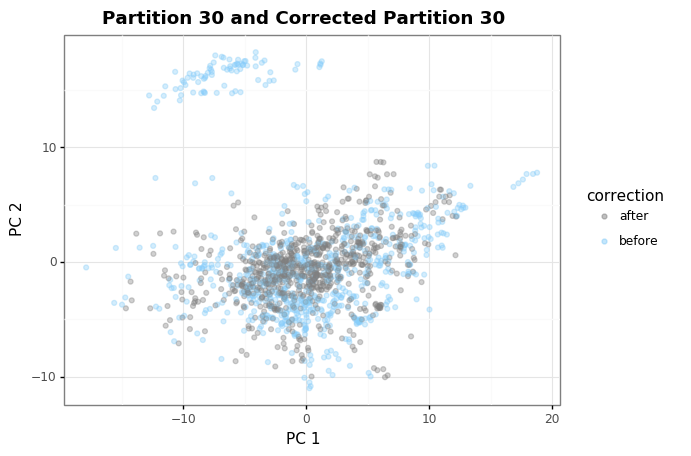

<ggplot: (-9223363258260671109)>
Plotting PCA of 1 partition vs 50 partitions...


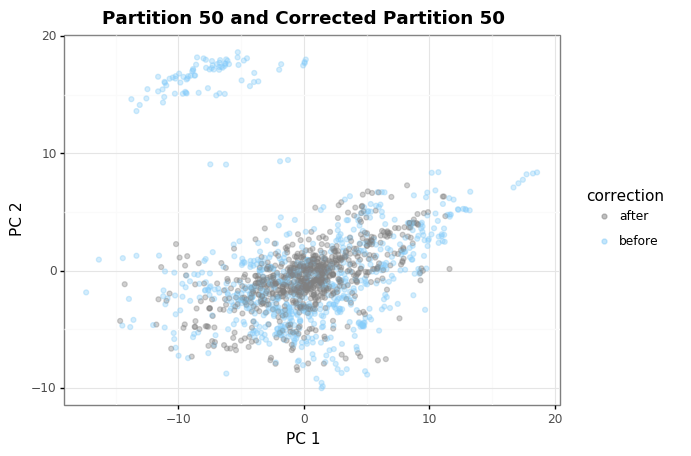

<ggplot: (8778515106368)>
Plotting PCA of 1 partition vs 70 partitions...


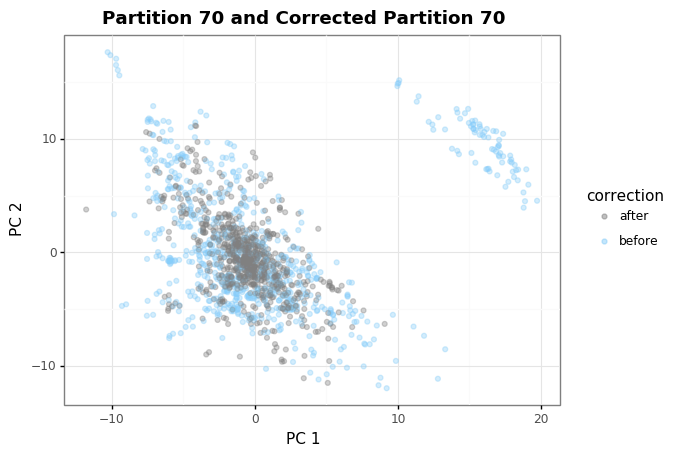

<ggplot: (8778523206036)>
Plotting PCA of 1 partition vs 100 partitions...


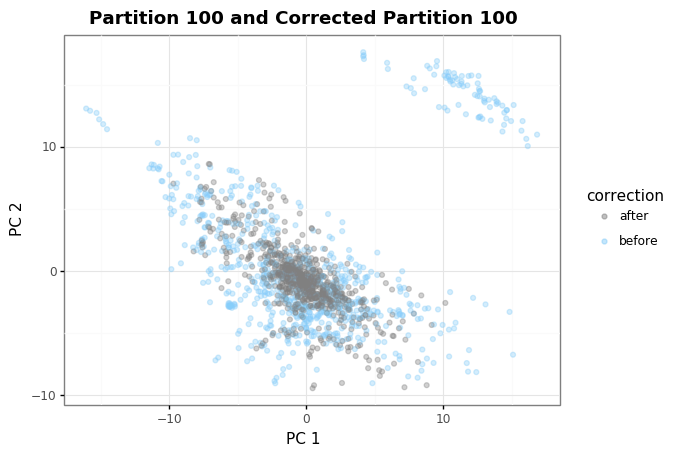

<ggplot: (-9223363258260886766)>
CPU times: user 40.1 s, sys: 11.1 s, total: 51.2 s
Wall time: 29.9 s


In [18]:
%%time

all_data_df = pd.DataFrame()

for i in lst_num_partitions:
    print('Plotting PCA of 1 partition vs {} partitions...'.format(i))
    
    # Get data BEFORE correction
    partition_before_file = os.path.join(
        partition_dir,
        "Partition_"+str(i)+".txt.xz")

    partition_before = pd.read_table(
        partition_before_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Match format of column names in before and after df
    partition_before.columns = partition_before.columns.astype(str)
    
    # Add grouping column for plotting
    partition_before['correction'] = "before"
    
    # Get data AFTER correction
    partition_after_file = os.path.join(
        partition_dir,
        "Partition_corrected_"+str(i)+".txt.xz")

    partition_after = pd.read_table(
        partition_after_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Transpose data to df: sample x gene
    partition_after = partition_after.T
    
    # Match format of column names in before and after df
    #experiment_after.columns = experiment_after.columns.astype(str)
    
    # Add grouping column for plotting
    partition_after['correction'] = "after"
        
    # Concatenate datasets together
    combined_data_df = pd.concat([partition_before, partition_after])
    
    # PCA projection
    pca = PCA(n_components=2)

    # Encode expression data into 2D PCA space    
    combined_data_numeric_df = combined_data_df.drop(['correction'], axis=1)    
    combined_data_PCAencoded = pca.fit_transform(combined_data_numeric_df)

    
    combined_data_PCAencoded_df = pd.DataFrame(combined_data_PCAencoded,
                                               index=combined_data_df.index,
                                               columns=['PC1', 'PC2']
                                              )
    
    # Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
    combined_data_PCAencoded_df['correction'] = combined_data_df['correction']
    
    # Add column that designates which batch effect comparision (i.e. comparison of 1 batch vs 5 batches
    # is represented by label = 5)
    combined_data_PCAencoded_df['num_partitions'] = str(i)
    
    # Concatenate ALL comparisons
    all_data_df = pd.concat([all_data_df, combined_data_PCAencoded_df])
    
    # Split dataframe in order to plot 'after' on top of 'before'
    df_layer_1 = combined_data_PCAencoded_df[combined_data_PCAencoded_df['correction'] == "before"]
    df_layer_2 = combined_data_PCAencoded_df[combined_data_PCAencoded_df['correction'] == "after"]

    
    # Plot individual comparisons
    print(ggplot(combined_data_PCAencoded_df, aes(x='PC1', y='PC2')) \
          + geom_point(aes(color='correction'), alpha=0.2) \
          + geom_point(df_layer_1, aes(color=['before']), alpha=0.2) \
          + geom_point(df_layer_2, aes(color=['after']), alpha=0.2) \
          + labs(x = "PC 1", y = "PC 2", title = "Partition {} and Corrected Partition {}".format(i, i)) \
          + theme_bw() \
          + theme(
                legend_title_align = "center",
                plot_background=element_rect(fill='white'),
                legend_key=element_rect(fill='white', colour='white'),
                plot_title=element_text(weight='bold')) \
          + scale_colour_manual(["grey", '#87CEFA'])
         )

In [19]:
# Convert 'comparison' into categories to preserve the ordering
num_partitions_cat = pd.Categorical(all_data_df['num_partitions'], categories=lst_num_partitions_str)

# Assign to a new column in the df
all_data_df = all_data_df.assign(num_partitions_cat = num_partitions_cat)

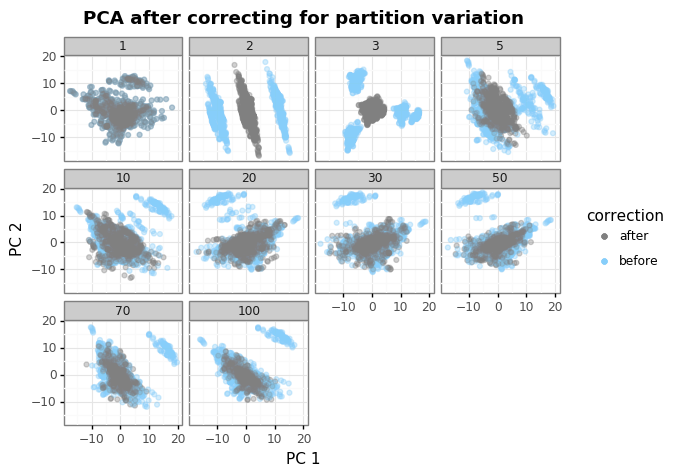

<ggplot: (-9223363258331621586)>


In [20]:
# Plot all comparisons in one figure

# Split dataframe in order to plot 'after' on top of 'before'
df_layer_1 = all_data_df[all_data_df['correction'] == "before"]
df_layer_2 = all_data_df[all_data_df['correction'] == "after"]

g_correct = ggplot(all_data_df, aes(x='PC1', y='PC2')) \
+ geom_point(aes(color='correction'), alpha=0.2) \
+ geom_point(df_layer_1, aes(color=['before']), alpha=0.2) \
+ geom_point(df_layer_2, aes(color=['after']), alpha=0.2) \
+ facet_wrap('~num_partitions_cat') \
+ labs(x = "PC 1", y = "PC 2", title = "PCA after correcting for partition variation") \
+ theme_bw() \
+ theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    plot_title=element_text(weight='bold')) \
+ guides(colour=guide_legend(override_aes={'alpha': 1})) \
+ scale_colour_manual(["grey", '#87CEFA'])

print(g_correct)
ggsave(plot = g_correct, filename = pca_correct_file, dpi=300)

## Permuted dataset (Negative control)

As a negative control we will permute the values within a sample, across genes in order to disrupt the gene expression structure.

In [21]:
# Read in permuated data
shuffled_simulated_data = pd.read_table(
    permuted_simulated_data_file,
    header=0,
    index_col=0,
    sep='\t')

In [22]:
# Label samples with label = perumuted
shuffled_simulated_data['group'] = "permuted"

# Concatenate original simulated data and shuffled simulated data
input_vs_permuted_df = pd.concat([original_data_df, shuffled_simulated_data])


input_vs_permuted = input_vs_permuted_df.drop(['group'], axis=1)
shuffled_data_PCAencoded = pca.fit_transform(input_vs_permuted)


shuffled_data_PCAencoded_df = pd.DataFrame(shuffled_data_PCAencoded,
                                           index=input_vs_permuted_df.index,
                                           columns=['PC1', 'PC2']
                                          )

# Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
shuffled_data_PCAencoded_df['group'] = input_vs_permuted_df['group']

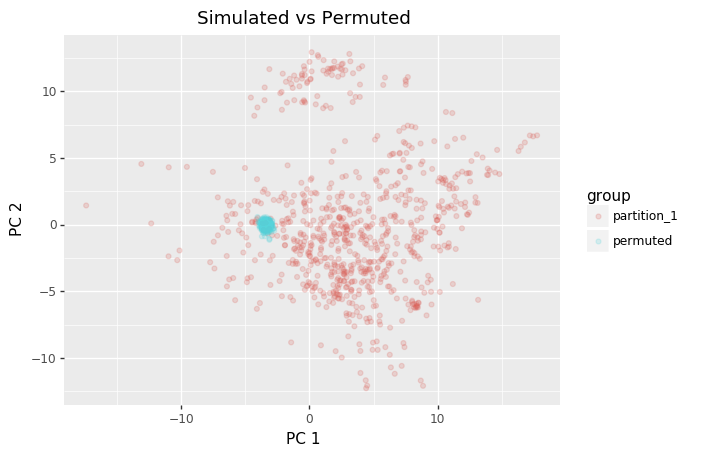

<ggplot: (8778428884621)>


In [23]:
# Plot permuted data
print(ggplot(shuffled_data_PCAencoded_df, aes(x='PC1', y='PC2')) \
      + geom_point(aes(color='group'), alpha=0.2) \
      + labs(x = "PC 1", y = "PC 2", title = "Simulated vs Permuted") \
     )